# Klasyfikacja półnadzorowana z pomocą klasteryzacji

## 1. Przygotowanie danych

- Generujemy dwa geometryczne zbiory danych:
  - `make_moons` – dwa zakrzywione klastry w kształcie półksiężyców.
  - `make_spirals` – dane 3-klasowe tworzące ramiona spirali.
- Normalizujemy dane przy użyciu `StandardScaler`.
- Losowo wybieramy 5% punktów jako dane etykietowane (pozostałe będą nieetykietowane).
- Tworzymy funkcję `plot_labeled_data`, która wizualizuje dane z etykietami (także `-1` jako nieetykietowane).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

MOONS = 'Moons'
SPIRALS = 'Spirals'

Funkcja generująca spirale z 3 klasami

In [2]:
def make_spirals(n_samples=1500, noise=0.05, n_classes=3):
    np.random.seed(0)
    n = n_samples // n_classes
    X, y = [], []
    for i in range(n_classes):
        theta = np.linspace(0, 4 * np.pi, n) + np.random.rand(n) * noise
        r = np.linspace(0.1, 1, n)
        xi = r * np.cos(theta + (2 * np.pi * i / n_classes))
        yi = r * np.sin(theta + (2 * np.pi * i / n_classes))
        X.extend(np.stack([xi, yi], axis=1))
        y.extend([i] * n)
    return np.array(X), np.array(y)

Losowe etykietowanie wybranego procenta danych

In [3]:
def mask_labels(y, percent_labeled=0.05):
    n = len(y)
    mask = np.full(n, -1)
    labeled_idx = np.random.choice(n, size=int(n * percent_labeled), replace=False)
    mask[labeled_idx] = y[labeled_idx]
    return mask

Funkcja zwracająca kolory dla poszczególnych etykiet

In [4]:
def get_label_color(label):
    if label == -1:
        return "lightgray"
    else:
        cmap = plt.get_cmap(f"tab10")
        return cmap(label % 10)


Funkcja wizualizacyjna

In [5]:
def plot_labeled_data(data, show_grey=True):
    n = len(data)
    _, axes = plt.subplots(1, n, figsize=(6 * n, 6))

    if n == 1:
        axes = [axes]

    for ax, (X, y, title) in zip(axes, data):
        unique_labels = sorted(set(y) if show_grey else set(y[y != -1]))

        for label in unique_labels:
            if label == -1 and not show_grey:
                continue
            mask = y == label
            color = get_label_color(label)
            ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=15, label=str(label))

        ax.set_title(title)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


Generowanie i normalizacja danych

In [6]:
X_moons, y_moons = make_moons(n_samples=2000, noise=0.1, random_state=0)
X_spirals, y_spirals = make_spirals(n_samples=3000, noise=0.2, n_classes=3)

scaler = StandardScaler()
X_moons = scaler.fit_transform(X_moons)
X_spirals = scaler.fit_transform(X_spirals)

Początkowo celem poprawnego wyświetlenia danych etykietujemy wszystkie z nich

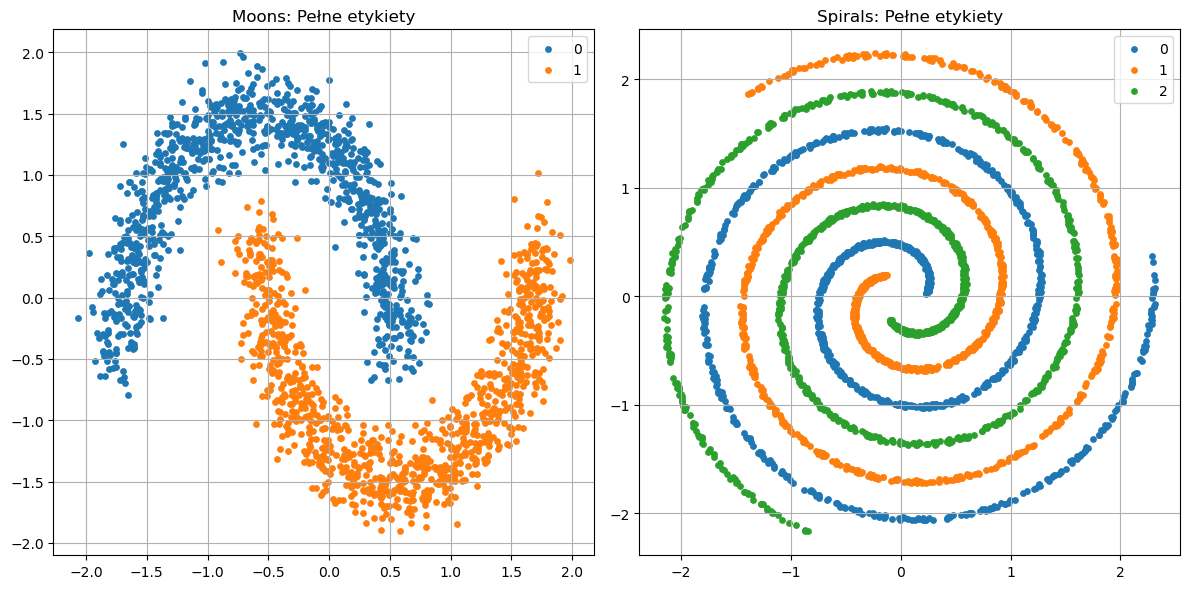

In [7]:
correct_y_moons = mask_labels(y_moons,1)
correct_y_spirals = mask_labels(y_spirals,1)

plot_labeled_data([
    (X_moons, correct_y_moons, f"{MOONS}: Pełne etykiety"),
    (X_spirals, correct_y_spirals, f"{SPIRALS}: Pełne etykiety")
])

Etykietujemy już tylko 5% danych

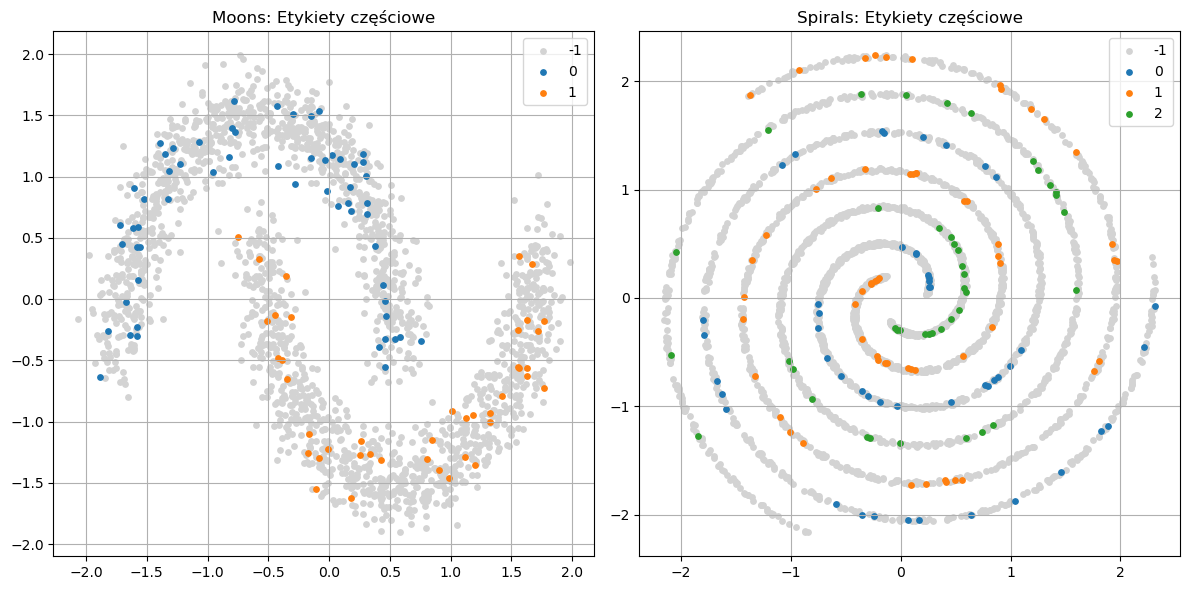

In [8]:
y_moons_partial = mask_labels(y_moons)
y_spirals_partial = mask_labels(y_spirals)

plot_labeled_data([
    (X_moons, y_moons_partial, f"{MOONS}: Etykiety częściowe"),
    (X_spirals, y_spirals_partial, f"{SPIRALS}: Etykiety częściowe")
])

## 2. Klasteryzacja i zgadywanie etykiet

- Wykorzystamy trzy metody klasteryzacji (`SpectralClustering`, `AgglomerativeClustering`, `Birch`) do zgadywania etykiet na podstawie struktury danych.
- Dla każdego punktu bez etykiety:
  - sprawdzimy, do którego klastra należy,
  - przypiszemy mu etykietę na podstawie większości znanych etykiet w tym klastrze.
- W efekcie powstaną pełne zbiory etykiet (`guessed labels`) dla dalszego treningu.

In [9]:
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, Birch
from collections import Counter

Funkcja przypisująca etykiety klastrom na podstawie znanych przykładów

In [10]:
def infer_labels_from_clusters(cluster_labels, known_labels):
    label_map = {}
    for cluster in np.unique(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        known_in_cluster = known_labels[indices]
        known_in_cluster = known_in_cluster[known_in_cluster != -1]
        if len(known_in_cluster) == 0:
            label_map[cluster] = -1
        else:
            label_map[cluster] = Counter(known_in_cluster).most_common(1)[0][0]
    return np.array([label_map[cluster] for cluster in cluster_labels])

Funkcja sprawdzająca poprawność przypisania etykiet

In [11]:
def calculate_labeling_accuracy(guessed_labels, dataset_name):
    if dataset_name == MOONS:
        ground_truth = correct_y_moons
    elif dataset_name == SPIRALS:
        ground_truth = correct_y_spirals
    else:
        raise ValueError(f"Unknown dataset name '{dataset_name}'")

    valid_idx = ground_truth != -1
    correct = (guessed_labels[valid_idx] == ground_truth[valid_idx]).sum()
    total = valid_idx.sum()
    return correct / total if total > 0 else 0.0

Klasteryzacja i zgadywanie etykiet

In [12]:
def run_clustering_and_infer_labels(X, known_labels, method="kmeans", C=3):
    if method == "spectral":
        model = SpectralClustering(n_clusters=C, affinity='nearest_neighbors', random_state=0)

    elif method == "agglomerative":
        model = AgglomerativeClustering(n_clusters=C, linkage='ward')

    elif method == "birch":
        model = Birch(n_clusters=C)

    else:
        raise ValueError(f"Unknown clustering method: {method}")

    cluster_labels = model.fit_predict(X)
    guessed_labels = infer_labels_from_clusters(cluster_labels, known_labels)
    return cluster_labels, guessed_labels

Faktyczne testy klastrowania, oraz wybór najlepszej metody do dlszego treningu

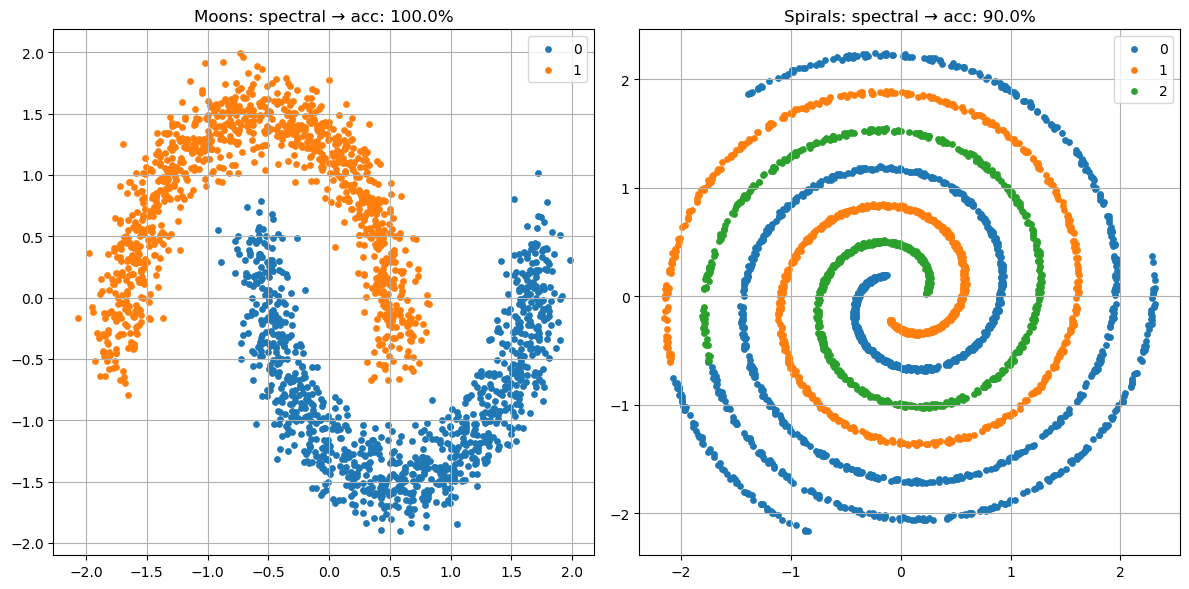

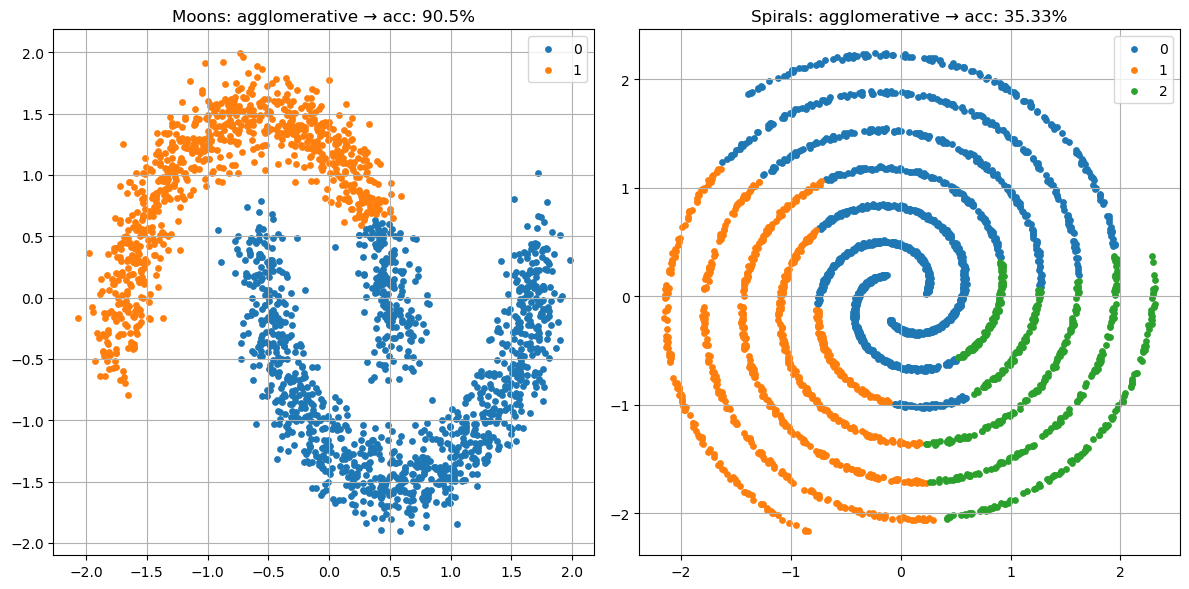

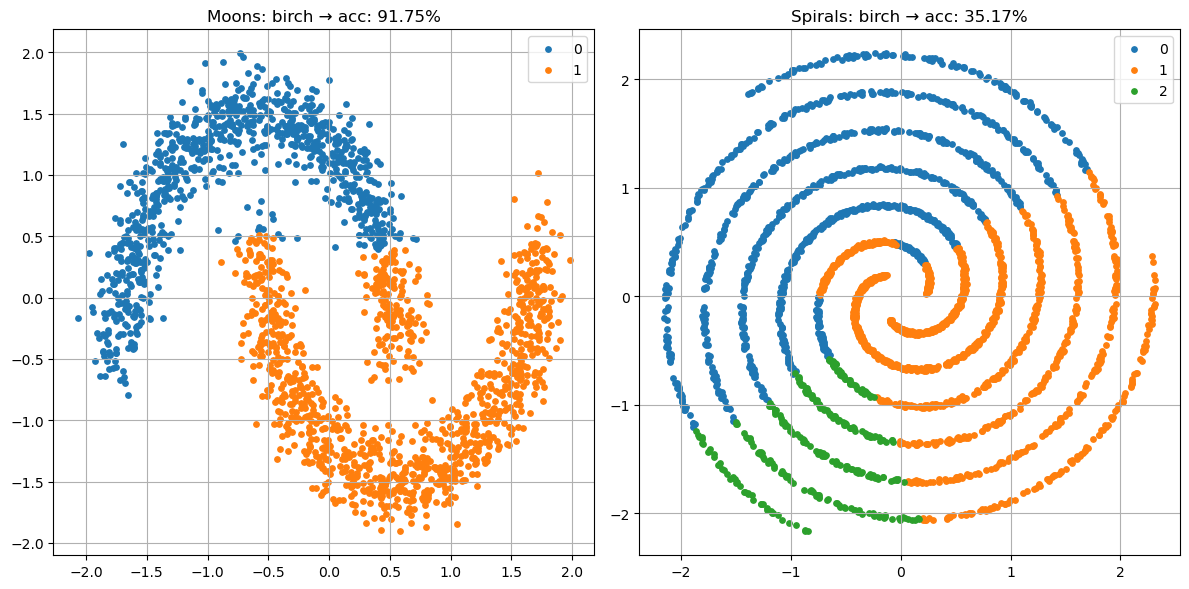

In [13]:
methods = ["spectral", "agglomerative", "birch"]
results = []

best_accuracy = 0.0
best_method = None

for name in methods:
    cl_m, gl_m = run_clustering_and_infer_labels(X_moons, y_moons_partial, method=name, C=2)
    cl_s, gl_s = run_clustering_and_infer_labels(X_spirals, y_spirals_partial, method=name, C=3)
    moon_accuracy = calculate_labeling_accuracy(gl_m, MOONS)
    spiral_accuracy = calculate_labeling_accuracy(gl_s, SPIRALS)
    mean_accuracy = (moon_accuracy + spiral_accuracy) / 2
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_method = name
    sub_results = [(MOONS, cl_m, f"{MOONS}: {name} → acc: {round(100*moon_accuracy, 2)}%"),
                   (SPIRALS, cl_s, f"{SPIRALS}: {name} → acc: {round(100*spiral_accuracy, 2)}%")]
    results.append(sub_results)
    plot_labeled_data([(X_moons if result[0] == MOONS else X_spirals, result[1], result[2]) for result in sub_results])

_, guessed_labels_moons = run_clustering_and_infer_labels(X_moons, y_moons_partial, method=best_method, C=2)
_, guessed_labels_spirals = run_clustering_and_infer_labels(X_spirals, y_spirals_partial, method=best_method, C=3)

Na podstawie wyników klasteryzacji metodami:

- `Spectral Clustering`: 
  - Moons: **100.0%**
  - Spirals: **90.0%**
- `Agglomerative Clustering`:
  - Moons: **90.5%**
  - Spirals: **35.33%**
- `Birch`:
  - Moons: **91.75%**
  - Spirals: **35.17%**

możemy wyciągnąć następujące wnioski:

`Spectral Clustering` zdecydowanie najlepiej radzi sobie zarówno z zadaniami liniowymi (moons), jak i nieliniowymi (spirals).  
Zarówno `Agglomerative`, jak i `Birch` działają zadowalająco dla księżyców, ale zupełnie nie radzą sobie z bardziej złożoną strukturą spiral — ich wydajność oscyluje w granicach losowego przypisania (~33%).  

W dalszych etapach to `Spectral Clustering` będzie preferowaną metodą do "zgadywania" etykiet w przypadku, gdy dane mają złożoną strukturę geometryczną.


## 3. Trening klasyfikatora

- Połączymy dane z etykietami oryginalnymi oraz zgadywanymi (z kroku 2), tworząc zbiór treningowy.
- Pozostałe dane posłużą jako zbiór testowy.
- Przeszkolimy klasyfikator (np. `MLPClassifier`) na tych danych.
- Ocenimy jakość klasyfikacji na danych testowych.

Celem jest sprawdzenie, na ile dobrze model klasyfikuje, mając dostęp tylko do 5% prawdziwych etykiet i reszty „zgadywanych”.


In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Funkcja trenująca klasyfikator i testująca na reszcie danych

In [15]:
def train_and_evaluate_classifier(X, partial_labels, guessed_labels):
    train_mask = (partial_labels != -1) | (guessed_labels != -1)
    y_train = np.where(partial_labels != -1, partial_labels, guessed_labels)

    test_mask = (partial_labels == -1) & (guessed_labels == -1)

    X_train, y_train = X[train_mask], y_train[train_mask]
    X_test = X[test_mask]

    if len(X_test) == 0:
        return np.array([]), test_mask

    clf = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    return y_pred, test_mask

Testowanie klasyfikatora na zbiorze danych

In [16]:
def mask_out_part_of_guessed_labels(partial_labels, guessed_labels, percent_kept=0.9):
    guessed_mask = (partial_labels == -1) & (guessed_labels != -1)
    indices = np.where(guessed_mask)[0]

    keep_size = int(len(indices) * percent_kept)
    if keep_size == 0:
        return np.full_like(guessed_labels, -1)

    kept_indices = np.random.choice(indices, size=keep_size, replace=False)

    masked = np.full_like(guessed_labels, -1)
    masked[kept_indices] = guessed_labels[kept_indices]

    return masked

Użycie na danych

In [17]:
guessed_labels_moons_filtered = mask_out_part_of_guessed_labels(y_moons_partial, guessed_labels_moons)
guessed_labels_spirals_filtered = mask_out_part_of_guessed_labels(y_spirals_partial, guessed_labels_spirals)

y_pred_moons, test_mask_moons = train_and_evaluate_classifier(X_moons, y_moons_partial, guessed_labels_moons_filtered)
y_pred_spirals, test_mask_spirals = train_and_evaluate_classifier(X_spirals, y_spirals_partial, guessed_labels_spirals_filtered)

Ocena dokładności (w oparciu o pełne etykiety)

In [18]:
moons_test_acc = accuracy_score(correct_y_moons[test_mask_moons], y_pred_moons)
spirals_test_acc = accuracy_score(correct_y_spirals[test_mask_spirals], y_pred_spirals)

Wizualizacja wyników klasyfikatora na zbiorze testowym

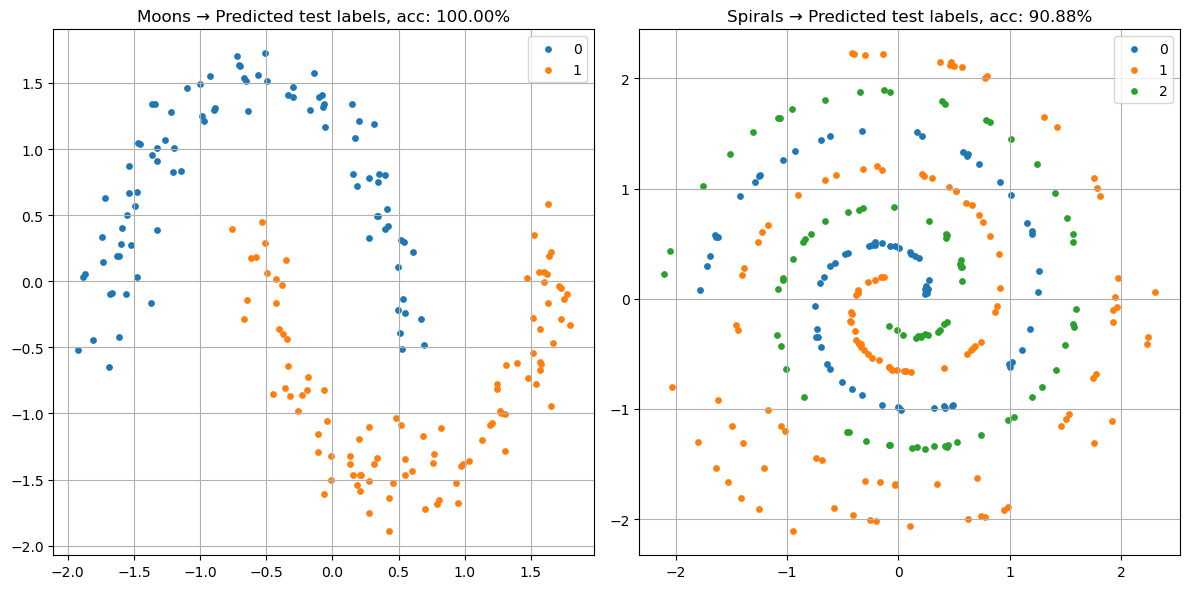

In [19]:
viz_labels_moons = np.full_like(correct_y_moons, -1)
viz_labels_moons[test_mask_moons] = y_pred_moons

viz_labels_spirals = np.full_like(correct_y_spirals, -1)
viz_labels_spirals[test_mask_spirals] = y_pred_spirals

plot_labeled_data([
    (X_moons, viz_labels_moons, f"{MOONS} → Predicted test labels, acc: {moons_test_acc * 100:.2f}%"),
    (X_spirals, viz_labels_spirals, f"{SPIRALS} → Predicted test labels, acc: {spirals_test_acc * 100:.2f}%")
], show_grey = False)

### Wnioski
  - Klasyfikator (MLP) został nauczony na:
  - punktach z częściowymi etykietami (5%)
  - punktach z etykietami zgadywanymi przez algorytmy klasteryzacji

#### `make_moons`
- **Skuteczność testowa**: `100.00%`
- Model poradził sobie perfekcyjnie – zarówno klasteryzacja (spectral), jak i klasyfikator oddzieliły dwie klasy bezbłędnie.
- Dane mają wyraźną, dobrze oddzieloną strukturę, co ułatwia proces nauki.

#### `make_spirals`
- **Skuteczność testowa**: `90.88%`
- Wynik jest bardzo dobry, biorąc pod uwagę:
  - trudność geometryczną danych (przeplatające się klasy),
  - fakt, że tylko 5% punktów było oznaczonych.
- Wysoka jakość przypisanych etykiet przez `spectral clustering` pomogła uzyskać trafne predykcje.

#### Wnioski ogólne:
- Jakość etykiet po klasteryzacji ma istotny wpływ na finalną skuteczność klasyfikatora.
- Najlepsze efekty osiągnięto, gdy klasy były geometrycznie dobrze rozdzielne i kiedy klasteryzacja uchwyciła tę strukturę (np. Spectral dla spirali).

## 4. Ewaluacja i eksperymenty

- Obliczymy metryki jakości dla klasyfikatora: `accuracy` i `f1-score` dla każdego zbioru danych.
- Powtórzymy cały proces (maskowanie, klasteryzacja, zgadywanie etykiet, trening i test) 3 razy, by uśrednić wyniki.
- Dodatkowo przetestujemy różne wartości liczby klastrów `C`, by sprawdzić ich wpływ na jakość zgadywania i klasyfikacji.

Zbadamy:
- Jak stabilne są wyniki względem losowego wyboru oznaczonych punktów.
- Dla których wartości `C` jakość klasyfikatora jest najwyższa.


In [20]:
from sklearn.metrics import accuracy_score, f1_score
from collections import defaultdict
import pandas as pd

C_values = [2, 3, 4]  
repeats = 3
methods = [best_method]
dataset_info = [(X_moons, y_moons, MOONS), (X_spirals, y_spirals, SPIRALS)]

results_summary = defaultdict(list)

Pętla eksperymentalna

In [21]:
for C in C_values:
    for repeat in range(repeats):
        for X, y_true, name in dataset_info:
            partial = mask_labels(y_true, percent_labeled=0.05)
            _, guessed = run_clustering_and_infer_labels(X, partial, method="spectral", C=C)

            filtered = mask_out_part_of_guessed_labels(partial, guessed, percent_kept=0.5)
            test_mask = (partial == -1) & (filtered == -1)

            y_pred, test_mask = train_and_evaluate_classifier(X, partial, filtered)

            if len(y_pred) == 0:
                print(f"Pominięto iterację {repeat+1} dla {name}, C={C} — brak danych testowych.")
                continue

            acc = accuracy_score(y_true[test_mask], y_pred)
            f1 = f1_score(y_true[test_mask], y_pred, average='macro')
            results_summary[(name, C)].append((acc, f1))

Podsumowanie wyników

In [22]:
summary_rows = []

for (name, C), scores in results_summary.items():
    accs, f1s = zip(*scores)
    row = {
        "Dataset": name,
        "C": C,
        "Accuracy (mean)": round(np.mean(accs), 4),
        "Accuracy (std)": round(np.std(accs), 4),
        "F1-score (mean)": round(np.mean(f1s), 4),
        "F1-score (std)": round(np.std(f1s), 4),
    }
    summary_rows.append(row)

results_df = pd.DataFrame(summary_rows)
display(results_df)

,Dataset,C,Accuracy (mean),Accuracy (std),F1-score (mean),F1-score (std)
0,Moons,2,0.9996,0.0005,0.9996,0.0005
1,Spirals,2,0.6470,0.0074,0.5355,0.0034
2,Moons,3,1.0000,0.0000,1.0000,0.0000
3,Spirals,3,0.9039,0.0015,0.9050,0.0018
4,Moons,4,0.9996,0.0005,0.9996,0.0005
5,Spirals,4,0.7425,0.0106,0.7468,0.0115


### Przebieg eksperymentu:
- Dla każdej liczby klastrów `C ∈ {2, 3, 4}`:
  - Losowano 5% znanych etykiet.
  - Resztę próbowano odgadnąć przez klasteryzację (`spectral`).
  - Trenowano klasyfikator (MLP) na etykietach znanych + zgadywanych.
  - Testowano na pozostałych danych (test set).
  - Proces powtórzono 3 razy, obliczając średnią dokładność (`accuracy`) i F1-score.

---

### Wyniki:

#### Zbiór: **Moons**
| C | Accuracy (mean) | F1-score (mean) |
|--:|-----------------:|----------------:|
| 2 | 0.9996           | 0.9996          |
| 3 | 1.0000           | 1.0000          |
| 4 | 0.9996           | 0.9996          |

- Bardzo dobre wyniki bliskie 100% niezależnie od `C`.
- Dane `moons` są łatwe do rozdzielenia przez klasyfikator po dobrym "zgadywaniu" etykiet przez klasteryzację.

#### Zbiór: **Spirals**
| C | Accuracy (mean) | F1-score (mean) |
|--:|-----------------:|----------------:|
| 2 | 0.6470           | 0.5355          |
| 3 | 0.9039           | 0.9050          |
| 4 | 0.7425           | 0.7468          |

- Najlepsze wyniki uzyskano dla `C = 3`, co odpowiada liczbie ramion spirali (czyli klas).
- Dla `C = 2` lub `C = 4` jakość klasyfikacji spadła – niewłaściwe dopasowanie liczby klastrów do struktury danych skutkuje słabym przypisaniem etykiet.

---

### Wnioski końcowe:
- Odpowiedni dobór liczby klastrów `C` w fazie klasteryzacji ma krytyczne znaczenie.
- Dane `moons` są bardzo "wdzięczne" dla tego typu procedury – model uczy się doskonale nawet przy zgadywaniu.
- Dla bardziej skomplikowanych danych (`spirals`) wybór `C` zgodny z rzeczywistą liczbą klas daje zauważalnie lepsze wyniki.

## 5. Eksperyment kontrolny

- Trenujemy klasyfikator wyłącznie na dostępnych rzeczywistych etykietach (`partial_labels`).
- Nie używamy etykiet zgadywanych przez klasteryzację.
- Porównujemy dokładność i F1-score na zbiorze testowym (czyli tych przykładach, których etykiet nie znaliśmy od początku).

Celem jest sprawdzenie, **czy warto wykonywać etap klasteryzacji i zgadywania etykiet**, czy może klasyfikator radzi sobie równie dobrze wyłącznie z garścią oznaczonych danych.


Funkcja trenująca klasyfikator bez etapu zgadywania

In [23]:
def train_classifier_without_guessing(X, partial_labels):
    train_mask = partial_labels != -1
    test_mask = partial_labels == -1

    X_train, y_train = X[train_mask], partial_labels[train_mask]
    X_test = X[test_mask]

    clf = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=500, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return y_pred, test_mask

Użycie i ocena

In [24]:
y_pred_moons_control, test_mask_moons_control = train_classifier_without_guessing(X_moons, y_moons_partial)
y_pred_spirals_control, test_mask_spirals_control = train_classifier_without_guessing(X_spirals, y_spirals_partial)

acc_moons_control = accuracy_score(correct_y_moons[test_mask_moons_control], y_pred_moons_control)
f1_moons_control = f1_score(correct_y_moons[test_mask_moons_control], y_pred_moons_control, average='macro')

acc_spirals_control = accuracy_score(correct_y_spirals[test_mask_spirals_control], y_pred_spirals_control)
f1_spirals_control = f1_score(correct_y_spirals[test_mask_spirals_control], y_pred_spirals_control, average='macro')

Wizualizacja

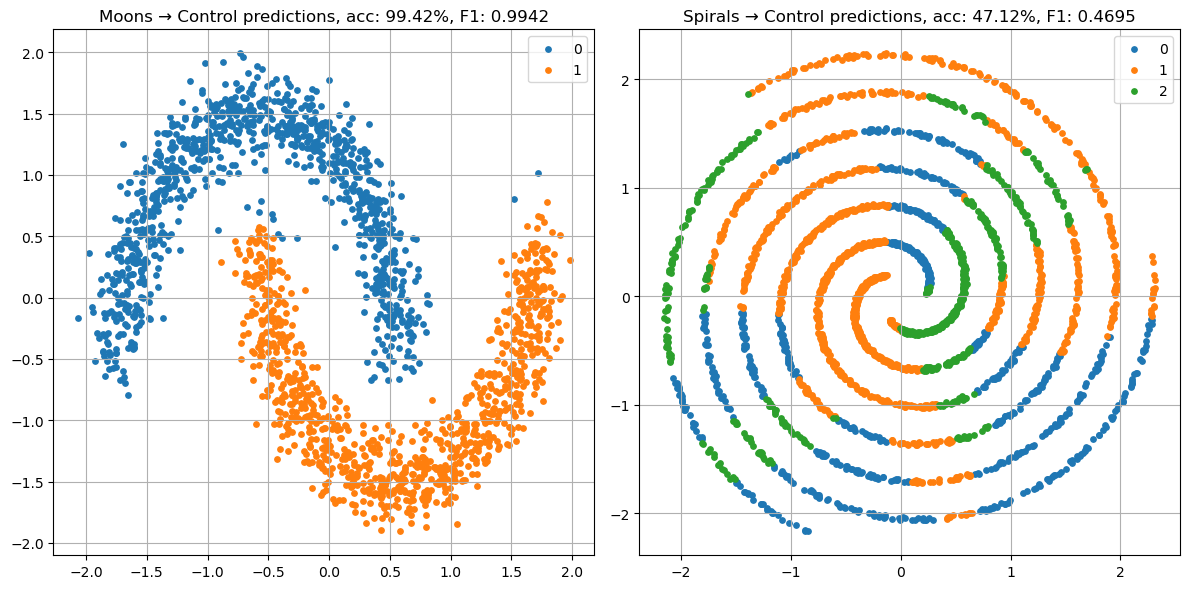

In [25]:
viz_labels_moons_control = np.full_like(correct_y_moons, -1)
viz_labels_moons_control[test_mask_moons_control] = y_pred_moons_control

viz_labels_spirals_control = np.full_like(correct_y_spirals, -1)
viz_labels_spirals_control[test_mask_spirals_control] = y_pred_spirals_control

plot_labeled_data([
    (X_moons, viz_labels_moons_control, f"{MOONS} → Control predictions, acc: {acc_moons_control * 100:.2f}%, F1: {f1_moons_control:.4f}"),
    (X_spirals, viz_labels_spirals_control, f"{SPIRALS} → Control predictions, acc: {acc_spirals_control * 100:.2f}%, F1: {f1_spirals_control:.4f}")
], show_grey=False)

### Wnioski z eksperymentu kontrolnego

- **Zbiór Moons**:
  - Accuracy: **99.42%**, F1-score: **0.9942**
  - Klasyfikator osiągnął bardzo wysoką skuteczność nawet bez etapu zgadywania etykiet.
  - Dzięki prostemu, dobrze separowalnemu rozkładowi danych, 5% oznaczeń wystarczyło do efektywnej nauki.
  - Etap klasteryzacji poprawił wynik jedynie marginalnie (do 100%), nie był kluczowy.

- **Zbiór Spirals**:
  - Accuracy: **47.12%**, F1-score: **0.4695**
  - Przy zaledwie 5% oznaczonych danych, klasyfikator nie był w stanie nauczyć się rozróżniania klas spiralnych.
  - Zgadywanie etykiet metodami klasteryzacji (np. Spectral Clustering) okazało się **niezbędne**, zwiększając accuracy nawet do ~90%.
  - Wnioski: w przypadku danych o złożonej geometrii, **uzupełnianie etykiet przez klasteryzację znacząco poprawia skuteczność klasyfikatora**.


### 6. Eksperymenty zaawansowane

Wykonamy uproszczoną wersję eksperymentu z użyciem sieci grafowych, opartą na `sklearn` + `networkx`:

- Zbudujemy graf podobieństw między punktami (np. k-NN).
- Przetestujemy klasyfikację z propagacją etykiet:
  - Użyjemy `Label Spreading` z `sklearn.semi_supervised`.
  - Jest to prosty model propagacji etykiet po grafie, który pełni rolę uproszczonego GNN.

**Cel**: sprawdzić, czy klasyfikacja bazująca na strukturze grafowej (bez klasyfikatora typu MLP) może skutecznie propagować etykiety i osiągnąć wysokie wyniki.

**Wyniki porównamy** z dotychczasowymi rezultatami klasyfikatorów wspieranych przez klasteryzację.


In [26]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score

Funkcja do propagacji etykiet za pomocą grafu

In [27]:
def label_spreading_graph_experiment(X, y, percent_labeled=0.05, kernel='knn', n_neighbors=10) :
    y_partial = mask_labels(y, percent_labeled=percent_labeled)

    model = LabelSpreading(kernel=kernel, n_neighbors=n_neighbors)
    model.fit(X, y_partial)

    test_mask = (y_partial == -1)
    y_pred = model.transduction_[test_mask]
    
    acc = accuracy_score(y[test_mask], y_pred)
    f1 = f1_score(y[test_mask], y_pred, average='macro')
    
    return acc, f1, y_partial, model.transduction_

In [28]:
acc_moons_ls, f1_moons_ls, y_moons_partial_ls, pred_moons = label_spreading_graph_experiment(X_moons, y_moons)
acc_spirals_ls, f1_spirals_ls, y_spirals_partial_ls, pred_spirals = label_spreading_graph_experiment(X_spirals, y_spirals)

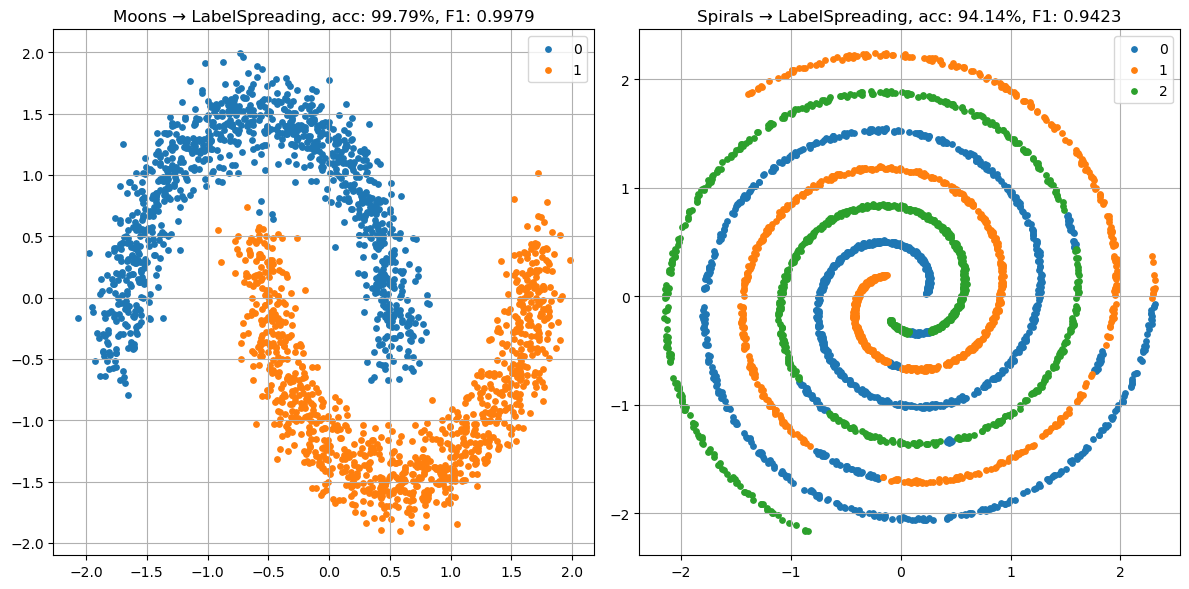

In [29]:
plot_labeled_data([
    (X_moons, pred_moons, f"{MOONS} → LabelSpreading, acc: {acc_moons_ls * 100:.2f}%, F1: {f1_moons_ls:.4f}"),
    (X_spirals, pred_spirals, f"{SPIRALS} → LabelSpreading, acc: {acc_spirals_ls * 100:.2f}%, F1: {f1_spirals_ls:.4f}")
])

W ramach eksperymentów opcjonalnych przetestowano klasyfikację przy użyciu metody `LabelSpreading`, która stanowi prostą formę grafowej propagacji etykiet (inspiracja GNN).

### Ustawienia:
- Algorytm: `LabelSpreading(kernel='knn', n_neighbors=10)`
- Procent danych oznaczonych: 5%
- Dwa zbiory danych:
  - `make_moons` (2 klasy)
  - `make_spirals` (3 klasy)

---

### Wyniki:

| Dataset  | Accuracy | F1-score |
|----------|----------|----------|
| Moons    | 99.79%   | 0.9979   |
| Spirals  | 94.14%   | 0.9423   |

---

### Wnioski:

- **LabelSpreading** bardzo dobrze radzi sobie z propagacją etykiet w danych o strukturze grafowej, szczególnie w przypadku `moons`, gdzie rozdzielność klas jest naturalna.
- W przypadku trudniejszego zadania (`spirals`) metoda osiąga znakomite wyniki, przewyższające klasyczny eksperyment kontrolny (F1=0.47).
- Ten wynik pokazuje potencjał metod grafowych w problemach z częściowo oznaczonymi danymi i uzasadnia eksplorację bardziej zaawansowanych architektur GNN (np. GCN, GAT).

## Wnioski końcowe

### 1. Dla jakiej liczby klastrów `C` uzyskano najlepszy wynik?

- Dla zbioru **Moons** najwyższe wyniki osiągnięto niezależnie od liczby klastrów (`C=2`, `C=3`, `C=4`), przy czym **C=3** dało idealne rezultaty (100% acc, 1.0 F1).
- Dla zbioru **Spirals** najlepsze wyniki uzyskano przy **C=3**:
  - Accuracy ≈ 90.39%
  - F1-score ≈ 0.905

### 2. Jak wypada porównanie wyników między klasyfikacją z i bez zgadywania etykiet?

| Dataset | Accuracy (guessing) | F1-score (guessing) | Accuracy (control) | F1-score (control) |
|---------|---------------------|----------------------|---------------------|---------------------|
| Moons   | 100.00%             | 1.0000               | 99.42%              | 0.9942              |
| Spirals | 90.53%              | 0.9053               | 47.12%              | 0.4695              |

- W przypadku **Moons** różnice są minimalne – klasyfikator dobrze generalizuje nawet bez zgadywania.
- W przypadku **Spirals** zgadywanie etykiet okazało się **kluczowe** – klasyfikacja bez niego dała bardzo niską jakość.

### 3. Jakie wyniki osiągają bardziej zaawansowane techniki?

- Użycie `LabelSpreading` (jako przykład prostego GNN-like podejścia) dało bardzo dobre wyniki:

| Dataset | Accuracy | F1-score |
|---------|----------|----------|
| Moons   | 99.79%   | 0.9979   |
| Spirals | 94.14%   | 0.9423   |

- **Lepsze niż klasyfikacja z użyciem zgadywania etykiet**, co pokazuje, że podejścia grafowe efektywnie wykorzystują strukturę danych i propagację lokalną.

---

Zgadywanie etykiet przez klasteryzację + nadzorowane uczenie działa bardzo dobrze, szczególnie dla prostych zbiorów. Jednak techniki takie jak `LabelSpreading` mogą osiągać jeszcze lepsze wyniki, co sugeruje zasadność eksploracji GNN i semi-supervised learning w zastosowaniach rzeczywistych.
